In [1]:
import os
import argparse
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, mannwhitneyu
from scipy.stats import spearmanr, pearsonr
from scipy.fftpack import fft
import sys
sys.path.append('/net/bgm/sherwood/NGS_analysis_proj/script/')
from access_util import *
from plotnine import *

from Bio.Seq import Seq
import pysam
from tqdm import tqdm
import tensorflow as tf
import ast




2024-11-26 16:05:43.214327: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 16:05:43.225225: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 16:05:43.261269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 16:05:43.320331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 16:05:43.338901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 16:05:46.453232: W tensorflow/compiler/tf2tensorrt/utils/p

### load reads and motif features

In [2]:
# load bam file
bam_path = f'/net/bgm/sherwood/UltimaGen_datasets/bulkATACseq/bowtie2_out/bam/merged/all/best_quality/062424_K562_concurrent_ACCESS-ATAC.dedup.hg38_core.bam'
bam = pysam.AlignmentFile(bam_path,'rb')

# load genome file
fasta_path = f'/net/bgm/sherwood/NGS_analysis_proj/data/ATACseq_041023/genome/hg38_core.fa'
fasta = pysam.FastaFile(fasta_path)

# load motif stats file
cell_type = 'K562'
rho_thres = 0.2
statsFile = f'/net/bgm/sherwood/factorbook_data/UltimaGen/stats/TF_summary.features_filtered_K562_modeled.csv'
df_motif_stats = pd.read_csv(statsFile)
df_motif_stats['center_pos_list'] = df_motif_stats['center_pos_list'].apply(lambda x: ast.literal_eval(x))
df_motif_stats['l_peak_pos_list'] = df_motif_stats['l_peak_pos_list'].apply(lambda x: ast.literal_eval(x))
df_motif_stats['r_peak_pos_list'] = df_motif_stats['r_peak_pos_list'].apply(lambda x: ast.literal_eval(x))
df_motif_stats = df_motif_stats.loc[(df_motif_stats['cell_type'] == cell_type) & (df_motif_stats['model_rho'] > rho_thres)].copy()

### load and filter STAT5A-STAT5A cobinding data

In [3]:
TF_name = 'STAT5A'
selected_center_dist = 21
shared_read_ct_thres=100
bound_filter_range = [0.01, 0.99]
adj_method_num = 3
cobind_statsDir = '/net/bgm/sherwood/factorbook_data/UltimaGen/cobinding_v2_read_thres50_rho0/K562_footprint_mean/'
# cobind_statsDir = '/net/bgm/sherwood/factorbook_data/UltimaGen/cobinding_v2_read_thres50_rho0/K562/'

df_cobinding = pd.read_csv(f'{cobind_statsDir}/K562_STAT5A_ENCSR000BRR_TTCYHRGAAMTGRRR.cobinding_stats.csv.gz')

# various filters
df_cobinding_bound = df_cobinding.loc[
    (df_cobinding['read_type_pair'] == 'bound--bound') & 
    (df_cobinding['shared_read_ct'] >= shared_read_ct_thres) &
    (df_cobinding['expected_probability'].between(bound_filter_range[0], bound_filter_range[1], inclusive='both')) &
    (df_cobinding['TF2'] == TF_name) &
    (df_cobinding['center_dist'] == selected_center_dist)
].copy()

# adjust center distance
df_cobinding_bound['center_dist'] = df_cobinding_bound.apply(lambda row: calc_center_distance_v2(row, df_motif_stats, adj_method_num=adj_method_num), axis=1)

df_cobinding_bound.sort_values('delta_oe_prob', ascending=True, inplace=True)
df_cobinding_bound['center_dist_raw'] = df_cobinding_bound.apply(lambda row: (row['center2']-row['center1']) if row['strand1']=='+' else (row['center1']-row['center2']), axis=1)
df_cobinding_bound.shape

(210, 51)

### extract STAT5A-STAT5A loci shared reads

In [4]:
def merge_read_info(list_1, list_2, center_dist_raw, check_overlap=False):
    if center_dist_raw > 0:
        list_1_overlap = list_1[center_dist_raw:]
        list_2_overlap = list_2[:len(list_1_overlap)]
        list_2_extra = list_2[len(list_1_overlap):]

        if check_overlap:
            if list_1_overlap != list_2_overlap:
                print('Overlap error!')
                return None
            
        list_merged = list_1 + list_2_extra

    elif center_dist_raw < 0:
        list_2_overlap = list_2[center_dist_raw:]
        list_1_overlap = list_1[:len(list_1_overlap)]
        list_1_extra = list_1[len(list_1_overlap):]

        if check_overlap:
            if list_1_overlap != list_2_overlap:
                print('Overlap error!')
                return None
            
        list_merged = list_2 + list_1_extra
        
    return list_merged

In [17]:
flank_len=150
selected_colnames = ['TF', 'chr', 'center', 'strand', 'flank_start', 'flank_end']
selected_colnames_2 = ['names', 'chr', 'center', 'strand', 'read_edit_type', 'edits', 'C2T_edits', 'G2A_edits', 'covs', 'editable_covs', 'editable_C_covs', 'editable_G_covs']
selected_colnames_3 = ['edits', 'C2T_edits', 'G2A_edits', 'covs', 'editable_covs', 'editable_C_covs', 'editable_G_covs' ]

df_shared_read_info_all = pd.DataFrame()
for index, row in tqdm(df_cobinding_bound.iterrows(), total=len(df_cobinding_bound), desc='Processing loci pairs ...'):
    row1 = row[[x+'1' for x in selected_colnames]]
    row2 = row[[x+'2' for x in selected_colnames]]
    row1.index = selected_colnames
    row2.index = selected_colnames

    if (row1['TF'] in df_motif_stats['TF'].tolist()) and (row2['TF'] in df_motif_stats['TF'].tolist()):
        # TF1 reads
        row_TF1 = df_motif_stats.loc[df_motif_stats['TF'] == row1['TF']].iloc[0]
        df_reads1 = motif_row_2_df_reads(bam, row1)
        if len(df_reads1):
            df_reads1 = prepare_df_reads_3readType_v2(df_reads1, row1, row_TF1, flank_len)

        # TF2 reads
        row_TF2 = df_motif_stats.loc[df_motif_stats['TF'] == row2['TF']].iloc[0]
        df_reads2 = motif_row_2_df_reads(bam, row2)
        if len(df_reads2):
            df_reads2 = prepare_df_reads_3readType_v2(df_reads2, row2, row_TF2, flank_len)

        # predict read types on shared reads
        df_reads1_shared = df_reads1.loc[df_reads1['names'].isin(df_reads2['names'])].copy()
        df_reads2_shared = df_reads2.loc[df_reads2['names'].isin(df_reads1['names'])].copy()

        # merge read info
        df_shared_read_info = pd.merge(df_reads1_shared[selected_colnames_2], df_reads2_shared[selected_colnames_2], on='names', suffixes=('_1', '_2'))
        df_shared_read_info['center_dist_raw'] = df_shared_read_info.apply(lambda row: (row['center_2'] - row['center_1']) if row['strand_1'] == '+' else (row['center_1'] - row['center_2']), axis=1)
        df_shared_read_info['delta_oe_prob'] = row['delta_oe_prob']
        for col_name in selected_colnames_3:
            df_shared_read_info[col_name+'_merged'] = df_shared_read_info.apply(lambda row: merge_read_info(row[col_name+'_1'], row[col_name+'_2'], row['center_dist_raw']), axis=1)

        # filter out reads with different read_edit_type for the two TFs
        # filter out reads with no/low edits
        df_shared_read_info = df_shared_read_info.loc[
            (df_shared_read_info['read_edit_type_1'] == df_shared_read_info['read_edit_type_2']) &
            (df_shared_read_info['read_edit_type_1'] != 'no_edits')
        ].copy()
        df_shared_read_info['read_edit_type'] = df_shared_read_info['read_edit_type_1']

        df_shared_read_info = df_shared_read_info[['center_dist_raw', 'delta_oe_prob', 'read_edit_type'] + [x+'_merged' for x in selected_colnames_3]].copy()
        df_shared_read_info_all = pd.concat([df_shared_read_info_all, df_shared_read_info], axis=0, ignore_index=True)

# save df_shared_read_info_all as pickle
df_shared_read_info_all.to_pickle(f'{cobind_statsDir}/K562_{TF_name}_center_dist_{selected_center_dist}_shared_read_info_all.pkl', compression='gzip')
df_shared_read_info_all

Processing loci pairs ...: 100%|██████████| 210/210 [05:54<00:00,  1.69s/it]


,center_dist_raw,delta_oe_prob,read_edit_type,edits_merged,C2T_edits_merged,G2A_edits_merged,covs_merged,editable_covs_merged,editable_C_covs_merged,editable_G_covs_merged
0,21,0.052032,mixed_edits,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,21,0.052032,G2A_dominant,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,21,0.052032,C2T_dominant,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,21,0.052032,C2T_dominant,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,21,0.052032,C2T_dominant,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...
79298,21,0.238944,C2T_dominant,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
79299,21,0.238944,C2T_dominant,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
79300,21,0.238944,C2T_dominant,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
79301,21,0.238944,C2T_dominant,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### reshape data for edit heatmap generation

In [ ]:
flank_len = 150
selected_center_dist = 21

# load df_shared_read_info_all from pickle 
df_shared_read_info_all = pd.read_pickle(f'{cobind_statsDir}/K562_{TF_name}_center_dist_{selected_center_dist}_shared_read_info_all.pkl', compression='gzip')

df_edits_all = pd.DataFrame()
df_shared_read_info = df_shared_read_info_all.loc[df_shared_read_info_all['read_edit_type'] == 'C2T_dominant'].copy()
df_edits = pd.DataFrame(df_shared_read_info['C2T_edits_merged'].to_list())
df_edits['delta_oe_prob'] = df_shared_read_info['delta_oe_prob'].values
df_edits['read_edit_type'] = 'C2T_dominant'
df_edits.reset_index(inplace=True)
df_edits_all = pd.concat([df_edits_all, df_edits], axis=0, ignore_index=True)

df_shared_read_info = df_shared_read_info_all.loc[df_shared_read_info_all['read_edit_type'] == 'G2A_dominant'].copy()
df_edits = pd.DataFrame(df_shared_read_info['G2A_edits_merged'].to_list())
df_edits['delta_oe_prob'] = df_shared_read_info['delta_oe_prob'].values
df_edits['read_edit_type'] = 'G2A_dominant'
df_edits.reset_index(inplace=True)
df_edits_all = pd.concat([df_edits_all, df_edits], axis=0, ignore_index=True)

df_edits_long = df_edits_all.melt(id_vars=['read_edit_type', 'index', 'delta_oe_prob'], var_name='relative_pos', value_name='edit')
df_edits_long['relative_pos'] = df_edits_long['relative_pos'] - flank_len
df_edits_long['relative_pos'] = df_edits_long['relative_pos'].astype(int)

df_edits_long.to_csv(f'{cobind_statsDir}/K562_{TF_name}_center_dist_{selected_center_dist}_shared_read_edits_long.csv.gz', index=False, compression='gzip')


### generate edit fraction data

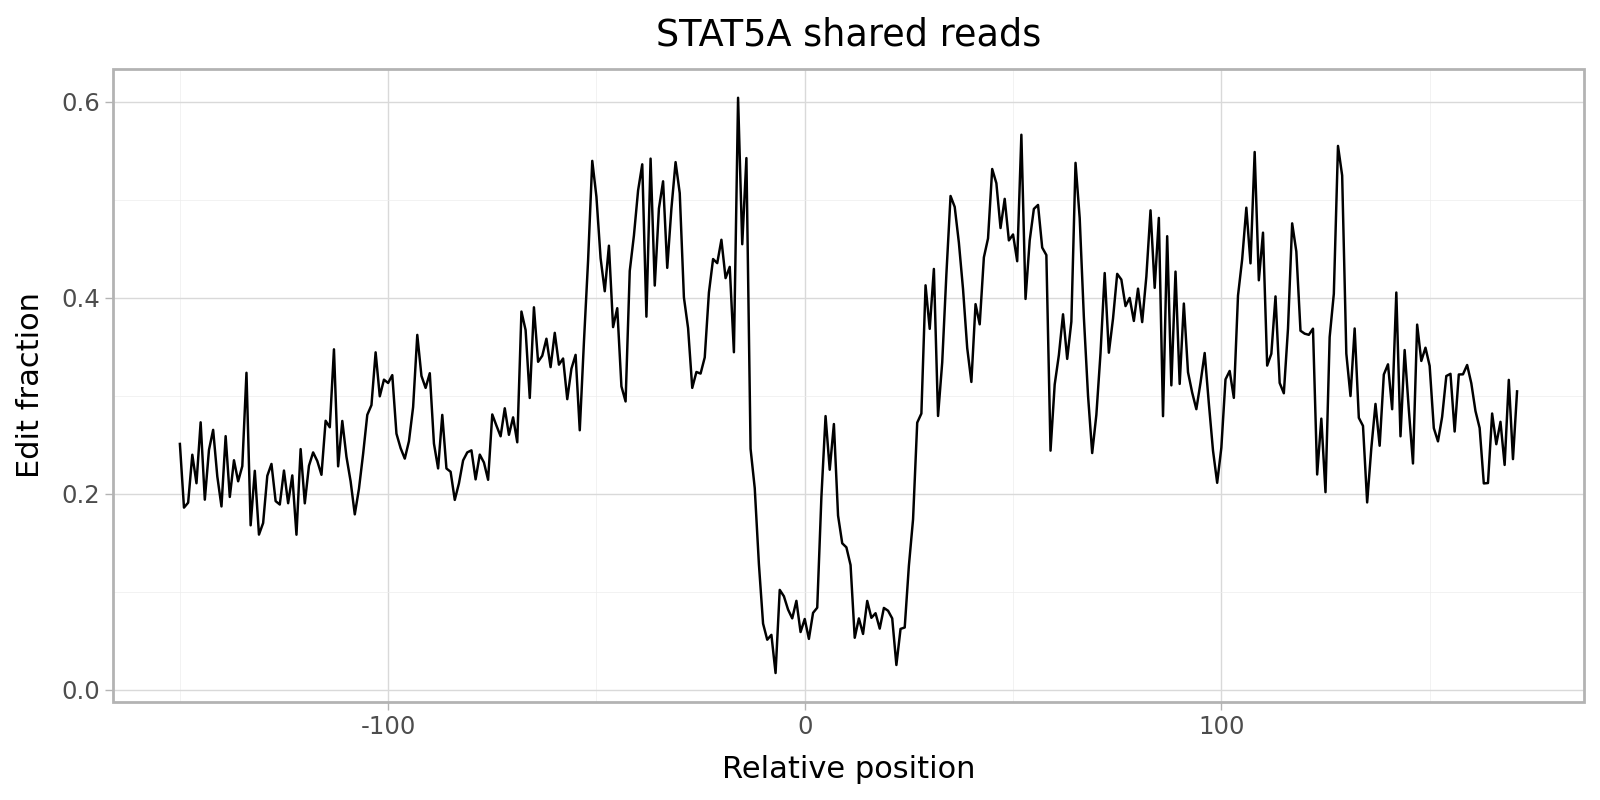

In [ ]:
flank_len = 150
selected_center_dist = 21

# load df_shared_read_info_all from pickle 
df_shared_read_info_all = pd.read_pickle(f'{cobind_statsDir}/K562_{TF_name}_center_dist_{selected_center_dist}_shared_read_info_all.pkl', compression='gzip')

# calculate edit fractions for shared reads
df_reads = df_shared_read_info_all.copy()
row = df_reads.iloc[0]
total_pos = len(row['edits_merged'])

edits = np.zeros(shape=total_pos)
covs = np.zeros(shape=total_pos)
for index, row in df_reads.iterrows():
    C2T_edits = np.array(row['C2T_edits_merged'])
    G2A_edits = np.array(row['G2A_edits_merged'])
    covs_G = np.array(row['editable_G_covs_merged'])
    covs_C = np.array(row['editable_C_covs_merged'])
    read_edit_type = row['read_edit_type']

    if read_edit_type == 'C2T_dominant':
        edits += C2T_edits
        covs += covs_C
    elif read_edit_type == 'G2A_dominant':
        edits += G2A_edits
        covs += covs_G
    else:
        edits += (C2T_edits + G2A_edits)
        covs += (covs_C + covs_G)

edit_frac = edits / covs
df_edit_frac = pd.DataFrame({'relative_pos': [x-flank_len for x in range(total_pos)], 'edit_frac': edit_frac})
df_edit_frac.to_csv(f'{cobind_statsDir}/K562_{TF_name}_center_dist_{selected_center_dist}_shared_read_edit_frac.csv', index=False)

plt = (
    ggplot(df_edit_frac, aes(x='relative_pos', y='edit_frac')) +
    geom_line() +
    theme_light() +
    labs(x='Relative position', y='Edit fraction', title=f'{TF_name} shared reads') +
    theme(figure_size=(8, 4))
)
plt.show()

### generate PWM for shared reads

In [42]:
flank_len = 150
selected_center_dist = 21

# get all motif pairs
ref_seq_list = []
orientation_list = []
for index, row in df_cobinding_bound.iterrows():
    if row['strand1'] == '+':
        ref_seq = fasta.fetch(row['chr1'], row['center1']-flank_len, row['center2']+flank_len+1)
    elif row['strand1'] == '-':
        ref_seq = fasta.fetch(row['chr1'], row['center2']-flank_len, row['center1']+flank_len+1)
        ref_seq = str(Seq(ref_seq).reverse_complement())

    if row['strand1'] == row['strand2']:
        orientation = 'same'
    else:
        orientation = 'opposite'
    ref_seq_list.append(ref_seq)
    orientation_list.append(orientation)
    
df_motif_pair_seqs = pd.DataFrame({'motif_pair_seqs': ref_seq_list, 'motif_pair_orientation': orientation_list})
df_motif_pair_seqs.to_csv(f'{cobind_statsDir}/K562_{TF_name}_center_dist_{selected_center_dist}_motif_pair_seqs.csv', index=False)
df_motif_pair_seqs
        

,motif_pair_seqs,motif_pair_orientation
0,GGTGGTCCTCACTGCTCATTTTACACTAATTATAACGCATTAGCAT...,same
1,GTGCCAGCCCCGAATGGGGCCGGGGGCAGTTCCTGTGTCCCCTTGG...,same
2,TGAAAACAAGTTTATTAAGAAAGCAAAGGAATAAAAGAATGGCTAC...,same
3,TGAAAGTACAGAGACTTGTTGCAAAGTGAAAAGTACACACTCAAGA...,same
4,GGTCATCCTCACTGCTCATTATATGCTAATTATAATGCATTAGAAT...,same
...,...,...
205,GGTCATCCTCACTGCTCATTATTTGCTAATTATAATGCATTAGCAT...,same
206,TAAATAAATAAATAAATAAAAACAGGAAAGGAATAAATGGGTGGCT...,same
207,AAAAGGCAAGAAGCTTTTATTGTGAAGTGAATGCCTGCGCACAGGA...,same
208,GCATCCTCCCTGCTCATTATATGCTAATTCGAATGCATTAGCATGC...,same


In [ ]:
stats_dir = '/net/bgm/sherwood/factorbook_data/UltimaGen/stats/'

df_stats = pd.read_csv(stats_dir + 'TF_summary.selected.csv')
df_stats_filtered = pd.DataFrame()

cell_type = "HepG2"
TF_list = ['ATF3', 'CTCF', 'HNF1A', 'HNF4A', 'NRF1']
df_stats1 = df_stats.loc[(df_stats['TF'].isin(TF_list)) & (df_stats['cell_type'] == 'HepG2')].copy()
df_stats_filtered = pd.concat([df_stats_filtered, df_stats1], ignore_index=True)

cell_type = "K562"
TF_list = ['ATF3', 'ATF4', 'CTCF', 'GATA1', 'NRF1', 'TAL1']
df_stats2 = df_stats.loc[(df_stats['TF'].isin(TF_list)) & (df_stats['cell_type'] == 'K562')].copy()
df_stats_filtered = pd.concat([df_stats_filtered, df_stats2], ignore_index=True)

df_stats_filtered


,cell_type,TF,motif,active_motif_ct,inactive_motif_ct,filtered_active_motif_ct,filtered_inactive_motif_ct,e_value
0,HepG2,ATF3,ENCSR000BKE_GGTSACGTGRB,2053,34960,2028,34960,0.0
1,HepG2,CTCF,ENCSR000BIE_VBRSYGCCMYCTGSTGGC,35677,110293,35653,110293,0.0
2,HepG2,HNF1A,ENCSR800QIT_YTGGTTAATGATTAAC,6831,34460,6615,34460,0.0
3,HepG2,HNF4A,ENCSR000BLF_BTGGACTTTGVMCYB,15414,145219,15414,145219,0.0
4,HepG2,NRF1,ENCSR853ADA_CWSTGCGCATGCGCV,30193,70517,29268,70517,0.0
5,K562,ATF3,ENCSR028UIU_NNKRTKRCRTCATC,13778,84117,13484,84117,0.0
6,K562,ATF4,ENCSR145TSJ_KRTTGCATCAKCYH,11750,123095,11544,123095,0.0
7,K562,CTCF,ENCSR000AKO_VBRGYGCCCCCTGSTGGC,35429,164062,35360,164062,0.0
8,K562,GATA1,ENCSR000EFT_BCTTATCWSNNNNNNVCAG,6978,112167,6497,112167,0.0
9,K562,NRF1,ENCSR998AJK_BGCGCATGCGCASDG,47193,67035,46700,67035,0.0


In [24]:
bedDir = '/net/bgm/sherwood/factorbook_data/UltimaGen/'
outDir = '/net/bgm/sherwood/NGS_analysis_proj/data/ACCESS_central/factorbook_peaks_KO/'
fimo_pVal_thres = -np.log10(0.0001)
chipseq_qVal_thres = -np.log10(0.05)

os.makedirs(outDir, exist_ok=True)
for index, row in df_stats_filtered.iterrows():
    cell_type = row['cell_type']
    TF_name = row['TF']
    motif_str = row['motif']
    motif_str2 = motif_str.split('_')[0]
    bed_path = bedDir + f'/{cell_type}/{TF_name}_{motif_str}.motifs.csv.gz'
    df_motifs = pd.read_csv(bed_path)

    df_motifs_filtered = filter_df_motifs(df_motifs, fimo_pVal_thres=fimo_pVal_thres, chipseq_qVal_thres=chipseq_qVal_thres)
    df_active_pool = df_motifs_filtered.loc[df_motifs_filtered['motif_type'] == 'Active'].copy()
    df_active_pool.sort_values('chipseq_signalVal', ascending=False, inplace=True)
    df_active_subset = df_active_pool.head(int(len(df_active_pool) * 0.25)).copy()
    print(f'active pool: {len(df_active_pool)}, active subset: {len(df_active_subset)}')
    df_active_subset[["chr", "start", "end", "strand", "score"]].to_csv(outDir + f'{motif_str2}_{cell_type}_{TF_name}.bed', index=False, header=False, sep='\t')


active pool: 2028, active subset: 507
active pool: 35653, active subset: 8913
active pool: 6615, active subset: 1653
active pool: 15414, active subset: 3853
active pool: 29268, active subset: 7317
active pool: 13484, active subset: 3371
active pool: 11544, active subset: 2886
active pool: 35360, active subset: 8840
active pool: 6497, active subset: 1624
active pool: 46700, active subset: 11675
active pool: 11532, active subset: 2883
